In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [85]:
args = {'lr':0.01,
        'epochs':5000,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'input features':20
        }

In [86]:
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [87]:
df = pd.read_excel('wide_range.xlsx')

In [88]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

In [89]:
linear_model = LinearRegression()
rfe = RFE(estimator=linear_model, n_features_to_select=args['input features'])

In [90]:
for layer in layers:
    col = layer['col']

    X_selected = rfe.fit_transform(X, y[col])
    selected_feature_indices = rfe.get_support(indices=True)
    
    features = []
    for i in selected_feature_indices:
        features.append(X.columns[i])

    layer['features'] = features

In [91]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X = X + noise

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

In [93]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[col].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[col].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [94]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForward, self).__init__()
        self.lin1 = nn.Linear(input_size, 15) 
        self.lin2 = nn.Linear(15, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin_fin = nn.Linear(5, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = self.lin_fin(x)
        return x

In [95]:
input_size = args['input features']
output_size = 1

criterion = nn.L1Loss()

In [96]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    model = FeedForward(input_size, output_size)

    best_loss = np.inf
    best_epoch = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

    print(layer['col'])

    for epoch in range(args['epochs']):
        outputs = model(input)

        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    layer['model'] = model

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
epoch: 500, loss = 2.954514265060425
epoch: 1000, loss = 2.815211534500122
epoch: 1500, loss = 4.068305492401123
epoch: 2000, loss = 3.7164883613586426
epoch: 2500, loss = 2.707280397415161
epoch: 3000, loss = 2.611889600753784
epoch: 3500, loss = 3.0513250827789307
epoch: 4000, loss = 2.4872779846191406
epoch: 4500, loss = 2.421640634536743
epoch: 5000, loss = 2.4596548080444336
best loss: 2.3580169677734375 in epoch 4912

layer 2
epoch: 500, loss = 4.180238723754883
epoch: 1000, loss = 3.590073347091675
epoch: 1500, loss = 3.3850913047790527
epoch: 2000, loss = 3.190293550491333
epoch: 2500, loss = 3.097029685974121
epoch: 3000, loss = 3.0352091789245605
epoch: 3500, loss = 2.8315980434417725
epoch: 4000, loss = 2.8356170654296875
epoch: 4500, loss = 2.718798875808716
epoch: 5000, loss = 2.7399463653564453
best loss: 2.340270757675171 in epoch 4162

layer 3
epoch: 500, loss = 2.872978925704956
epoch: 1000, loss = 3.6431753635406494
epoch: 1500, loss = 2.8707079887390137
epoch

In [97]:
test_losses = []
pred_df = pd.DataFrame()
for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = criterion(pred, target)
        test_losses.append(loss.item())

    pred_df[{layer["col"]}] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

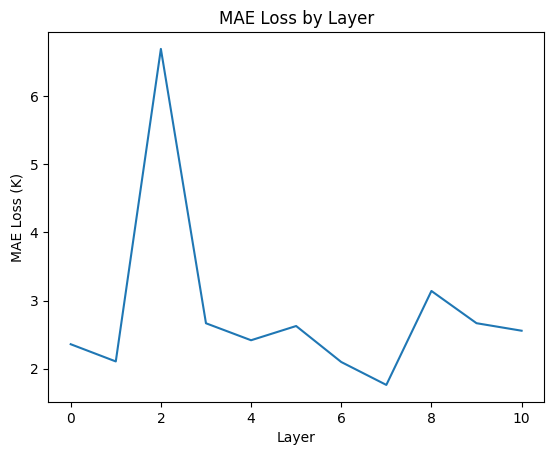

In [ ]:
plt.plot(test_losses)

plt.title("MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MAE Loss (K)")

plt.show()

In [ ]:
def plot_comparison(pred, actual):
    plt.title("Temperature Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Temperature")
    plt.plot(pred, 'r+', label='predicted')
    plt.plot(actual, 'g', label='actual')
    plt.show()

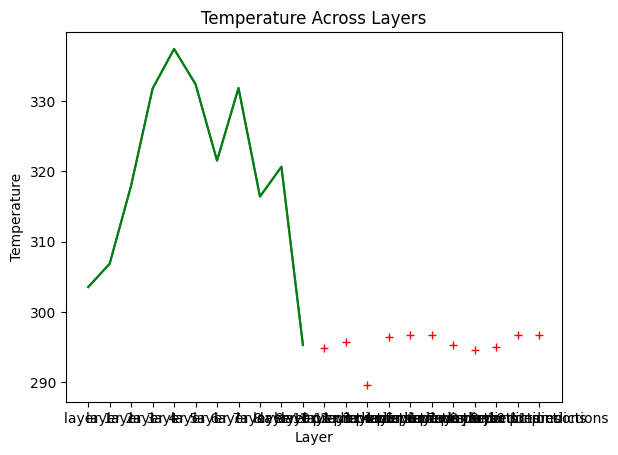

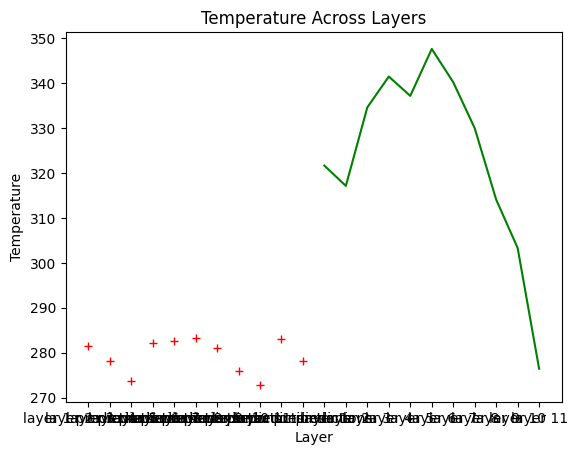

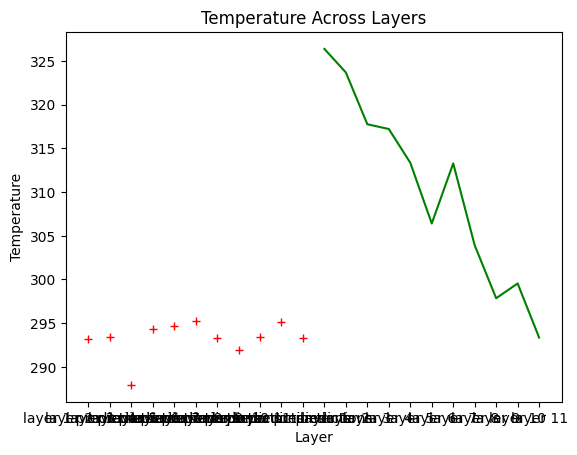

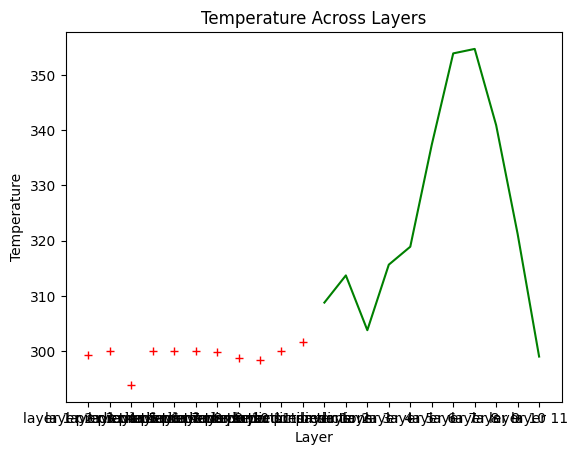

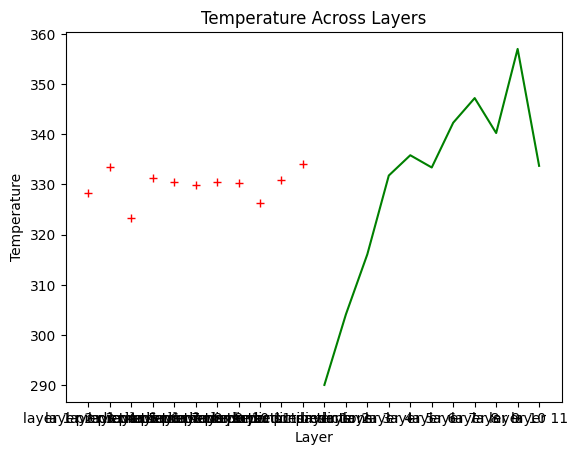

In [ ]:
plt.plot(y_test.iloc[0, :11])
plt.plot(y_train.iloc[0, 11:])

for i in range(0, len(y_test), int(len(y_test)/5)):
    actual = y_test.iloc[i, :11]
    pred = pred_df.iloc[i, 11:]

    plot_comparison(pred, actual)